In [1]:
pip install geopandas

  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached pyogrio-0.11.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (5.3 kB)
  Using cached pyproj-3.7.1-cp311-cp311-macosx_14_0_arm64.whl.metadata (31 kB)
  Using cached shapely-2.1.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached certifi-2025.7.14-py3-none-any.whl.metadata (2.4 kB)
Using cached geopandas-1.1.1-py3-none-any.whl (338 kB)
Using cached pyogrio-0.11.0-cp311-cp311-macosx_12_0_arm64.whl (19.5 MB)
Using cached pyproj-3.7.1-cp311-cp311-macosx_14_0_arm64.whl (4.7 MB)
Using cached shapely-2.1.1-cp311-cp311-macosx_11_0_arm64.whl (1.6 MB)
Using cached certifi-2025.7.14-py3-none-any.whl (162 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy.stats import kruskal
import matplotlib.pyplot as plt

In [12]:
# airbnb dataframe -> geodataframe

df = pd.read_csv("/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/csv_files/preprocessing_filtered.csv", index_col=0)

from shapely.geometry import Point
gdf_listings = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)],
    crs='EPSG:4326'
)


In [13]:
# pluto shapefile 불러오고 좌표계 통일

pluto = gpd.read_file("/Users/Jiwon/Downloads/nyc_mappluto_25v2_shp/MapPLUTO.shp").to_crs(epsg=4326)

In [20]:
list(pluto.columns)

['Borough',
 'Block',
 'Lot',
 'CD',
 'BCT2020',
 'BCTCB2020',
 'CT2010',
 'CB2010',
 'SchoolDist',
 'Council',
 'ZipCode',
 'FireComp',
 'PolicePrct',
 'HealthCent',
 'HealthArea',
 'Sanitboro',
 'SanitDistr',
 'SanitSub',
 'Address',
 'ZoneDist1',
 'ZoneDist2',
 'ZoneDist3',
 'ZoneDist4',
 'Overlay1',
 'Overlay2',
 'SPDist1',
 'SPDist2',
 'SPDist3',
 'LtdHeight',
 'SplitZone',
 'BldgClass',
 'LandUse',
 'Easements',
 'OwnerType',
 'OwnerName',
 'LotArea',
 'BldgArea',
 'ComArea',
 'ResArea',
 'OfficeArea',
 'RetailArea',
 'GarageArea',
 'StrgeArea',
 'FactryArea',
 'OtherArea',
 'AreaSource',
 'NumBldgs',
 'NumFloors',
 'UnitsRes',
 'UnitsTotal',
 'LotFront',
 'LotDepth',
 'BldgFront',
 'BldgDepth',
 'Ext',
 'ProxCode',
 'IrrLotCode',
 'LotType',
 'BsmtCode',
 'AssessLand',
 'AssessTot',
 'ExemptTot',
 'YearBuilt',
 'YearAlter1',
 'YearAlter2',
 'HistDist',
 'Landmark',
 'BuiltFAR',
 'ResidFAR',
 'CommFAR',
 'FacilFAR',
 'BoroCode',
 'BBL',
 'CondoNo',
 'Tract2010',
 'XCoord',
 'YCoo

In [25]:
# 공간 조인
gdf_joined = gpd.sjoin(
    gdf_listings,
    pluto[['LandUse', 'geometry']],
    how='left',
    predicate='within'
)


In [30]:
import pandas as pd

# 1) 문자열 코드(예: '02') → 정수 2 변환
#   1-1) 결측값 nan/None 은 '' 로 바꾸고
#   1-2) 왼쪽의 '0' 문자를 제거(.lstrip)
#   1-3) pd.to_numeric → 숫자(정수)로 변환, 실패하면 NaN
gdf_joined['LandUse_code'] = (
    gdf_joined['LandUse']
      .fillna('')               # nan/None → ''
      .str.lstrip('0')          # '01' → '1', '10' → '10'
)
gdf_joined['LandUse_code'] = pd.to_numeric(
    gdf_joined['LandUse_code'], errors='coerce'
).astype('Int64')               # pandas nullable integer


In [32]:


# LandUse → 4개 그룹 매핑
def lu4(code):
    # Residential: 1–3
    if code in (1, 2, 3):
        return 'Residential'
    # Commercial: Mixed(4) + Office(5)
    if code in (4, 5):
        return 'Commercial'
    # Industrial: Manufacturing(6) + Utility(7)
    if code in (6, 7):
        return 'Industrial'
    # Tourism: Public facilities(8) + Open space(9)
    if code in (8, 9):
        return 'Tourism'
    # 나머지(Parking(10), Vacant(11))는 None 또는 Other로 처리
    return None

gdf_joined['lu4_group'] = gdf_joined['LandUse_code'].map(lu4)

# 동별 4개 그룹 Count 집계
dist_count = (
    gdf_joined
      .dropna(subset=['lu4_group'])             # None 제거
      .groupby(['neighbourhood_cleansed','lu4_group'])
      .size()
      .unstack(fill_value=0)
)

# 동별 % 비율 계산
dist_pct = dist_count.div(dist_count.sum(axis=1), axis=0)

# 결과
print("=== Count ===")
print(dist_count)
print("\n=== Percentage ===")
print(dist_pct)

# CSV로 저장
dist_count.to_csv('neighborhood_lu4_count.csv')
dist_pct.to_csv('neighborhood_lu4_pct.csv')


=== Count ===
lu4_group               Commercial  Industrial  Residential  Tourism
neighbourhood_cleansed                                              
Allerton                         3           1           21        0
Arden Heights                    0           0            2        0
Arrochar                         0           0            5        1
Arverne                          2           1           31        8
Astoria                         42           7          131       14
...                            ...         ...          ...      ...
Windsor Terrace                  3           1           30        1
Woodhaven                        6           0           42        1
Woodlawn                         0           0            3        1
Woodrow                          0           0            1        0
Woodside                         8           8           66        7

[217 rows x 4 columns]

=== Percentage ===
lu4_group               Commercial  Industria

In [35]:
local_char = pd. read_csv('/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/2.eda/neighborhood_lu4_pct.csv')

,neighbourhood_cleansed,Commercial,Industrial,Residential,Tourism
0,Allerton,0.120000,0.040000,0.840000,0.000000
1,Arden Heights,0.000000,0.000000,1.000000,0.000000
2,Arrochar,0.000000,0.000000,0.833333,0.166667
3,Arverne,0.047619,0.023810,0.738095,0.190476
4,Astoria,0.216495,0.036082,0.675258,0.072165
...,...,...,...,...,...
212,Windsor Terrace,0.085714,0.028571,0.857143,0.028571
213,Woodhaven,0.122449,0.000000,0.857143,0.020408
214,Woodlawn,0.000000,0.000000,0.750000,0.250000
215,Woodrow,0.000000,0.000000,1.000000,0.000000


Cluster centers (LandUse proportions):
         Residential  Commercial    Industrial   Tourism
cluster                                                 
0           0.092593    0.064815  6.938894e-18  0.842593
1           0.578821    0.222761  4.447131e-02  0.153947
2           0.866359    0.048775  2.396772e-02  0.060898
3           0.182769    0.708419  3.075183e-02  0.078060

Kruskal-Wallis stat=61.799, p=2.426e-13
Cluster median occupancy days:
lu_cluster
0.0    0.0
1.0    0.0
2.0    0.0
3.0    0.0
Name: estimated_occupancy_l365d, dtype: float64


<Figure size 800x500 with 0 Axes>

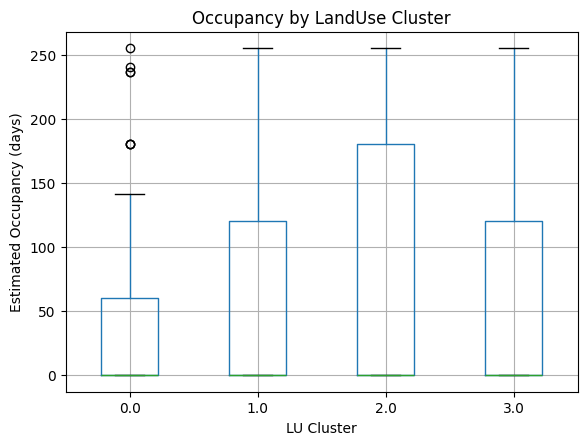

In [38]:
dist_count = (
    gdf_joined
      .dropna(subset=['lu4_group'])
      .groupby(['neighbourhood_cleansed','lu4_group'])
      .size()
      .unstack(fill_value=0)
)
# 컬럼 없으면 0 채우기
for col in ['Residential','Commercial','Industrial','Tourism']:
    if col not in dist_count.columns:
        dist_count[col] = 0
dist_count = dist_count[['Residential','Commercial','Industrial','Tourism']]
# 비율
dist_pct = dist_count.div(dist_count.sum(axis=1), axis=0).reset_index()

# 6) KMeans 군집화 (k=4)
features = ['Residential','Commercial','Industrial','Tourism']
k = min(4, len(dist_pct))
kmeans = KMeans(n_clusters=k, random_state=42).fit(dist_pct[features])
dist_pct['lu_cluster'] = kmeans.labels_

# 7) 클러스터 중심 확인
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
centers.index.name = 'cluster'
print("Cluster centers (LandUse proportions):")
print(centers)

# 8) 숙소(df)에 동별 클러스터 라벨 매핑
cluster_map = dist_pct.set_index('neighbourhood_cleansed')['lu_cluster']
df['lu_cluster'] = df['neighbourhood_cleansed'].map(cluster_map)

# 9) 군집별 예약일 분포 검정 (Kruskal‑Wallis)
valid = df.dropna(subset=['lu_cluster','estimated_occupancy_l365d'])
groups = [grp['estimated_occupancy_l365d'].values 
          for _,grp in valid.groupby('lu_cluster')]
stat, p = kruskal(*groups)
print(f"\nKruskal-Wallis stat={stat:.3f}, p={p:.4g}")

# 10) 군집별 중앙값 & 박스플롯
medians = valid.groupby('lu_cluster')['estimated_occupancy_l365d'].median()
print("Cluster median occupancy days:")
print(medians)

plt.figure(figsize=(8,5))
valid.boxplot(column='estimated_occupancy_l365d', by='lu_cluster')
plt.title('Occupancy by LandUse Cluster')
plt.suptitle('')
plt.xlabel('LU Cluster')
plt.ylabel('Estimated Occupancy (days)')
plt.show()

In [39]:
df

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,host_about_length_group,host_is_superhost,host_has_profile_pic,host_identity_verified,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_ny,host_location_boolean,lu_cluster
0,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,long,0,1,1,4.0,4,4,1,1,2.0
1,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,empty,0,1,1,4.0,4,4,1,1,1.0
2,Boerum Hill,Brooklyn,40.684420,-73.980680,765.0,0,0.0,49,326,0,...,long,0,1,1,3.0,4,2,1,1,1.0
3,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,long,1,1,1,4.0,4,4,1,1,1.0
4,Williamsburg,Brooklyn,40.710651,-73.950874,130.0,154,20020.0,22,38,0,...,long,1,1,1,4.0,4,4,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22303,Harlem,Manhattan,40.813794,-73.952399,72.0,0,0.0,53,358,0,...,empty,0,1,1,4.0,4,4,1,1,1.0
22304,Bedford-Stuyvesant,Brooklyn,40.685500,-73.919510,58.0,0,0.0,58,363,0,...,long,1,1,1,4.0,4,4,1,1,2.0
22305,Kips Bay,Manhattan,40.745290,-73.979380,299.0,0,0.0,39,99,0,...,empty,0,1,1,4.0,4,4,0,1,3.0
22306,Theater District,Manhattan,40.757133,-73.983124,200.0,0,0.0,60,365,1,...,long,0,1,1,4.0,4,4,1,1,3.0


In [43]:
# (1) 앞서 구한 centers DataFrame
print(centers)

# (2) 군집별로 비율이 가장 높은 LandUse 카테고리 뽑기
dominant = centers.idxmax(axis=1)
print("\nCluster별 우세 토지이용 유형:")
print(dominant)


         Residential  Commercial    Industrial   Tourism
cluster                                                 
0           0.092593    0.064815  6.938894e-18  0.842593
1           0.578821    0.222761  4.447131e-02  0.153947
2           0.866359    0.048775  2.396772e-02  0.060898
3           0.182769    0.708419  3.075183e-02  0.078060

Cluster별 우세 토지이용 유형:
cluster
0        Tourism
1    Residential
2    Residential
3     Commercial
dtype: object
